# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in `pierce_county_house_sales.csv`, car prices in `cars_hw.csv`, and airbnb rental prices in `airbnb_hw.csv`.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an 80/20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. Use the `sklearn.linear_model.Lasso` to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [20]:
! git clone https://github.com/Camsbary/lab_hedonic_pricing

fatal: destination path 'lab_hedonic_pricing' already exists and is not an empty directory.


Raw shape: (30478, 13)
    Host Id Host Since                             Name Neighbourhood   \
0   5162530        NaN  1 Bedroom in Prime Williamsburg       Brooklyn   
1  33134899        NaN  Sunny, Private room in Bushwick       Brooklyn   
2  39608626        NaN             Sunny Room in Harlem      Manhattan   

  Property Type  Review Scores Rating (bin)        Room Type  Zipcode  Beds  \
0     Apartment                         NaN  Entire home/apt  11249.0   1.0   
1     Apartment                         NaN     Private room  11206.0   1.0   
2     Apartment                         NaN     Private room  10032.0   1.0   

   Number of Records  Number Of Reviews Price  Review Scores Rating  
0                  1                  0   145                   NaN  
1                  1                  1    37                   NaN  
2                  1                  1    28                   NaN  
Index(['Host Id', 'Host Since', 'Name', 'Neighbourhood ', 'Property Type',
       '

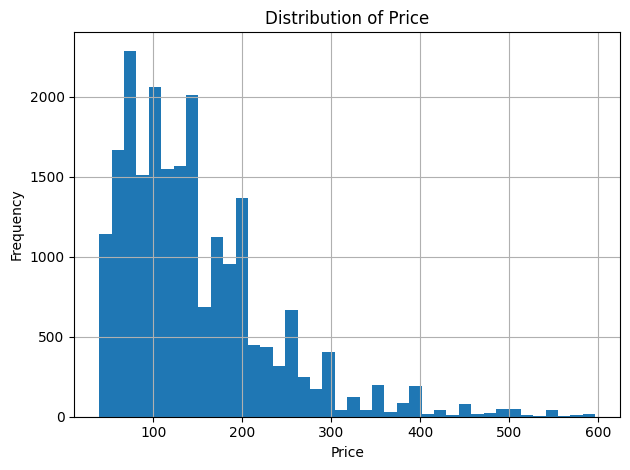

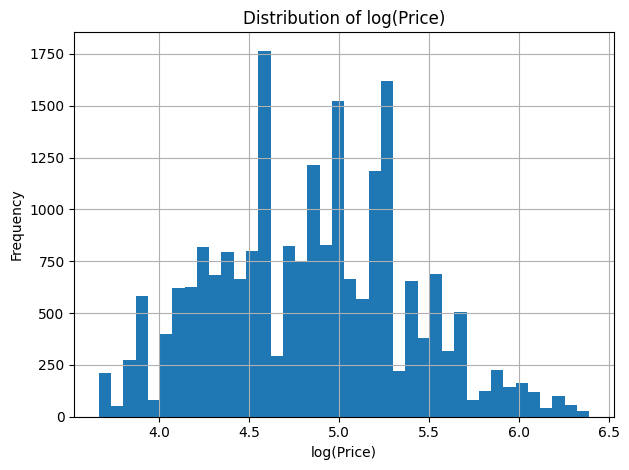

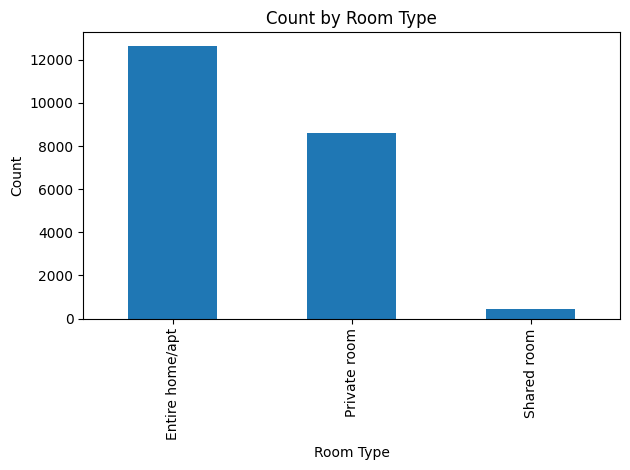

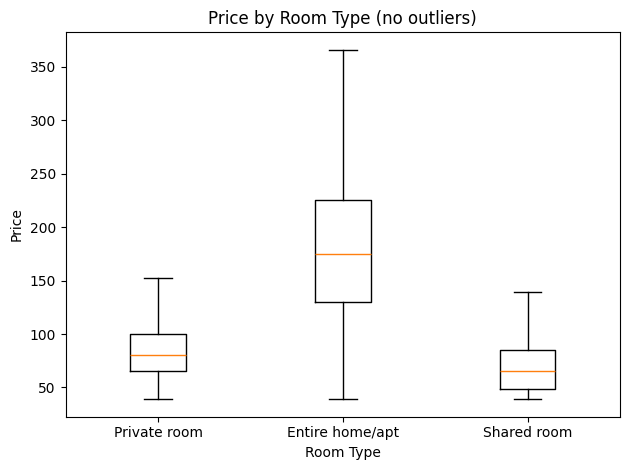

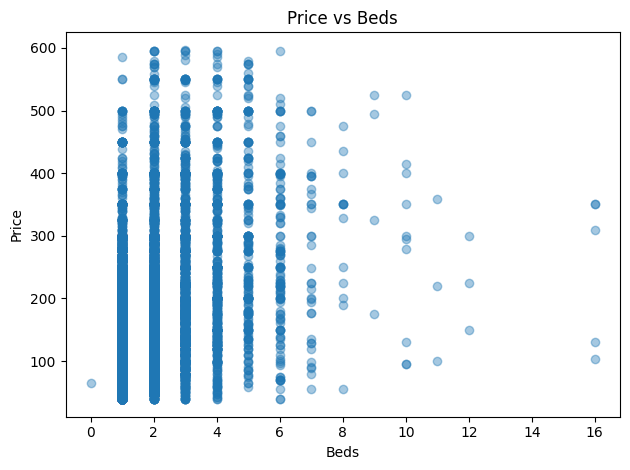

Saved cleaned file to /mnt/data/airbnb_clean.csv


In [21]:
#1


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('lab_hedonic_pricing/data/airbnb_hw.csv')
print("Raw shape:", df.shape)
print(df.head(3))       # peek
print(df.columns)       # see exact column names

# Keep the columns we care about
needed = [
    'Price',
    'Beds',
    'Room Type',
    'Property Type',
    'Neighbourhood ',
    'Number Of Reviews',
    'Review Scores Rating'
]


# Basic Cleaning
# Price might be a string with symbols -> make it numeric
df['Price'] = (
    df['Price'].astype(str)
               .str.replace(r'[^0-9\.]', '', regex=True)
               .replace('', np.nan)
               .astype(float)
)

# Make numeric columns numeric (change errors to NaN)
df['Beds'] = pd.to_numeric(df['Beds'], errors='coerce')
df['Number Of Reviews'] = pd.to_numeric(df['Number Of Reviews'], errors='coerce')
df['Review Scores Rating'] = pd.to_numeric(df['Review Scores Rating'], errors='coerce')

# Drop rows with ANY missing in the needed columns
df_clean = df.dropna(subset=needed).copy()

# Keep only positive prices
df_clean = df_clean[df_clean['Price'] > 0]

# Trim extreme outliers (1st–99th percentiles) to make plots/models nicer
p1, p99 = df_clean['Price'].quantile([0.01, 0.99])
df_clean = df_clean[(df_clean['Price'] >= p1) & (df_clean['Price'] <= p99)]

# Feature engineering: log price
df_clean['log_price'] = np.log(df_clean['Price'])

print("Clean shape:", df_clean.shape)

# Quick summaries
print("\n=== Numeric summary ===")
print(df_clean[['Price','log_price','Beds','Number Of Reviews','Review Scores Rating']].describe())

print("\n=== Counts by Room Type ===")
print(df_clean['Room Type'].value_counts())

print("\n=== Mean Price by Neighbourhood ===")
print(df_clean.groupby('Neighbourhood ')['Price'].mean().sort_values(ascending=False))

# Histogram of Price
plt.figure()
df_clean['Price'].hist(bins=40)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Histogram of log(Price)
plt.figure()
df_clean['log_price'].hist(bins=40)
plt.title('Distribution of log(Price)')
plt.xlabel('log(Price)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Bar: counts by Room Type
plt.figure()
df_clean['Room Type'].value_counts().plot(kind='bar')
plt.title('Count by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Boxplot: Price by Room Type (hide outliers so scale is readable)
plt.figure()
groups = [df_clean.loc[df_clean['Room Type'] == rt, 'Price'] for rt in df_clean['Room Type'].unique()]
labels = list(df_clean['Room Type'].unique())
plt.boxplot(groups, tick_labels=labels, showfliers=False)
plt.title('Price by Room Type (no outliers)')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Scatter: Price vs Beds
plt.figure()
plt.scatter(df_clean['Beds'], df_clean['Price'], alpha=0.4)
plt.title('Price vs Beds')
plt.xlabel('Beds')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Save cleaned data
df_clean.to_csv('/content/airbnb_clean.csv', index=False)
print("Saved cleaned file to /mnt/data/airbnb_clean.csv")

We chose to use the airbnb rental prices data set.

In this data set, the price distribution is heavily right-skewed. Most Airbnb listings cost between 50 and 200 dollars per night, but there are a few very expensive listings that pull the distribution to the right.

After applying the log transformation, the price distribution becomes much more symmetric. This makes it a better variable for regression because it reduces the influence of extreme outliers.

Entire homes/apartments make up the largest share of listings, followed by private rooms. Shared rooms are much less common in this dataset.

Entire homes/apartments are generally much more expensive than private or shared rooms. Private rooms tend to be moderately priced, and shared rooms are usually the cheapest option.

There is a positive relationship between the number of beds and price. Listings with more beds usually cost more. However, the relationship is not perfectly linear and there is a lot of variation even among listings with the same number of beds.

In [22]:
#2
#Transform Variables for Regression

# Columns we want to keep for the hedonic model
model_cols = [
    'log_price',           # target variable
    'Beds',
    'Number Of Reviews',
    'Review Scores Rating',
    'Room Type',
    'Property Type',
    'Neighbourhood '
]

# Keep only those columns
df_model = df_clean[model_cols].copy()

# Convert categorical variables to dummy variables (one-hot encoding)
categorical = ['Room Type', 'Property Type', 'Neighbourhood '] # Corrected column name

df_model = pd.get_dummies(df_model, columns=categorical, drop_first=True)

print("Shape after dummy encoding:", df_model.shape)
df_model.head()

Shape after dummy encoding: (21696, 27)


,log_price,Beds,Number Of Reviews,Review Scores Rating,Room Type_Private room,Room Type_Shared room,Property Type_Bed & Breakfast,Property Type_Boat,Property Type_Bungalow,Property Type_Cabin,...,Property Type_Lighthouse,Property Type_Loft,Property Type_Other,Property Type_Townhouse,Property Type_Treehouse,Property Type_Villa,Neighbourhood _Brooklyn,Neighbourhood _Manhattan,Neighbourhood _Queens,Neighbourhood _Staten Island
4,6.308098,3.0,39,96.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
5,5.003946,1.0,4,100.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6,5.521461,1.0,9,100.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
7,4.499810,1.0,80,94.0,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
8,5.598422,2.0,95,90.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


This table shows the cleaned and transformed dataset that we will use for our hedonic pricing model. The target variable is log_price, which is the natural log of the listing’s nightly price. All the predictor variables are numeric now. For example, Beds, Number Of Reviews, and Review Scores Rating are continuous variables.

The categorical variables such as room type, property type, and neighborhood were converted into dummy variables (True/False columns). Each dummy variable represents whether or not a listing belongs to that specific category.

This transformation allows us to use these features in a regression model since machine learning algorithms require numeric inputs. The dataset now contains 27 columns, with one target and 26 features that can help predict the price of an Airbnb listing.

In [23]:
#3
from sklearn.model_selection import train_test_split

# Target variable (what we want to predict)
y = df_model['log_price']

# Features (everything else)
X = df_model.drop(columns=['log_price'])

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,     # 20% test set
    random_state=123,   # makes it reproducible
)

print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)


Training features shape: (17356, 26)
Test features shape: (4340, 26)
Training target shape: (17356,)
Test target shape: (4340,)


In [24]:
#4
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


#Model 1: numeric predictors only
num_cols = ['Beds', 'Number Of Reviews', 'Review Scores Rating']
X_train_1 = X_train[num_cols]
X_test_1 = X_test[num_cols]

model1 = LinearRegression()
model1.fit(X_train_1, y_train)

#predictions
yhat_train_1 = model1.predict(X_train_1)
yhat_test_1 = model1.predict(X_test_1)

#evaluate
rmse_train_1 = mean_squared_error(y_train, yhat_train_1)
rmse_test_1 = mean_squared_error(y_test, yhat_test_1)
r2_train_1 = r2_score(y_train, yhat_train_1)
r2_test_1 = r2_score(y_test, yhat_test_1)

print("Model 1: Numeric only")
print(f"Train RMSE: {rmse_train_1:.3f}, Test RMSE: {rmse_test_1:.3f}")
print(f"Train R²: {r2_train_1:.3f}, Test R²: {r2_test_1:.3f}")

#Model 2: Numeric + Room Type dummies
#find dummy variables for room type
room_cols = [c for c in X_train.columns if 'Room Type' in c]

X_train_2 = X_train[num_cols + room_cols]
X_test_2 = X_test[num_cols + room_cols]

model2 = LinearRegression()
model2.fit(X_train_2, y_train)

yhat_train_2 = model2.predict(X_train_2)
yhat_test_2 = model2.predict(X_test_2)

rmse_train_2 = mean_squared_error(y_train, yhat_train_2)
rmse_test_2 = mean_squared_error(y_test, yhat_test_2)
r2_train_2 = r2_score(y_train, yhat_train_2)
r2_test_2 = r2_score(y_test, yhat_test_2)

print("\nModel 2: Numeric + Room Type")
print(f"Train RMSE: {rmse_train_2:.3f}, Test RMSE: {rmse_test_2:.3f}")
print(f"Train R²: {r2_train_2:.3f}, Test R²: {r2_test_2:.3f}")

#Model 3: All features
X_train_3 = X_train.copy()
X_test_3 = X_test.copy()

model3 = LinearRegression()
model3.fit(X_train_3, y_train)

yhat_train_3 = model3.predict(X_train_3)
yhat_test_3 = model3.predict(X_test_3)

rmse_train_3 = mean_squared_error(y_train, yhat_train_3)
rmse_test_3 = mean_squared_error(y_test, yhat_test_3,)
r2_train_3 = r2_score(y_train, yhat_train_3)
r2_test_3 = r2_score(y_test, yhat_test_3)

print("\nModel 3 — All features")
print(f"Train RMSE: {rmse_train_3:.3f}, Test RMSE: {rmse_test_3:.3f}")
print(f"Train R²: {r2_train_3:.3f}, Test R²: {r2_test_3:.3f}")

Model 1: Numeric only
Train RMSE: 0.247, Test RMSE: 0.248
Train R²: 0.163, Test R²: 0.163

Model 2: Numeric + Room Type
Train RMSE: 0.146, Test RMSE: 0.145
Train R²: 0.506, Test R²: 0.511

Model 3 — All features
Train RMSE: 0.120, Test RMSE: 0.120
Train R²: 0.593, Test R²: 0.594


Model 1 didn't do too well, with equal test and training R^2 values of a low 0.163 and a high RMSE of 0.247/0.248. Model 2 improved a lot, with train and test R^2 values of around 0.51 and a lower RMSE of about 0.14. Finally, Model 3 did the best, with highest train and test R^2 values of above 0.59, and the lowest RMSE values of 0.12. So, Model 3 performed the best.

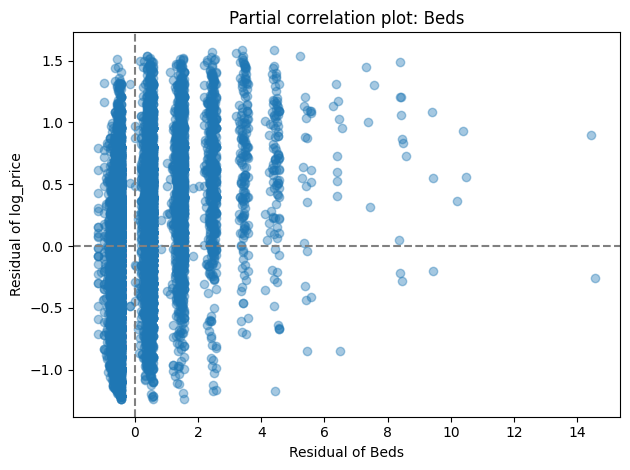

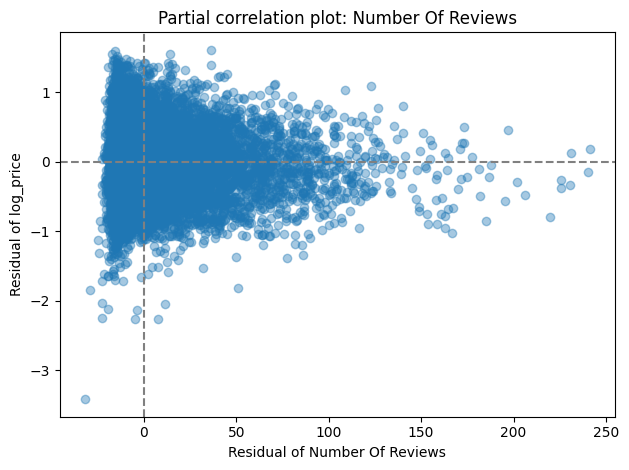

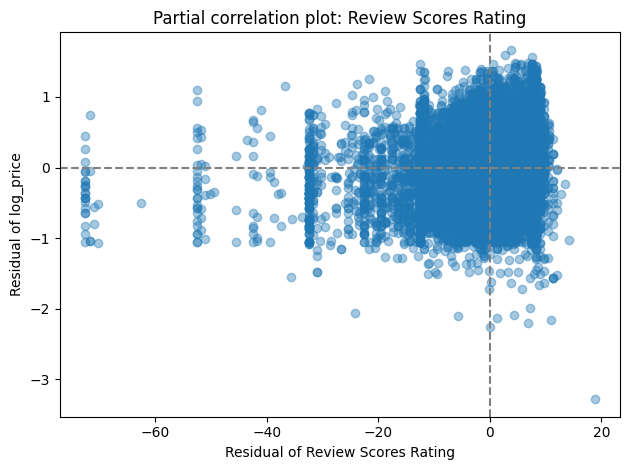

In [25]:
#5


# umeric columns only
num_cols = ['Beds', 'Number Of Reviews', 'Review Scores Rating']

# For partial plots: remove effects of *other* variables using residuals
for col in num_cols:
    # Predict log_price from all numeric variables *except* current one
    other_cols = [c for c in num_cols if c != col]
    lin1 = LinearRegression().fit(X_train[other_cols], y_train)
    y_resid = y_train - lin1.predict(X_train[other_cols])

    # Predict current feature from all *other* numeric features
    lin2 = LinearRegression().fit(X_train[other_cols], X_train[col])
    x_resid = X_train[col] - lin2.predict(X_train[other_cols])

    # Plot residuals
    plt.figure()
    plt.scatter(x_resid, y_resid, alpha=0.4)
    plt.xlabel(f"Residual of {col}")
    plt.ylabel("Residual of log_price")
    plt.title(f"Partial correlation plot: {col}")
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()

Looking at the first graph, the partial correlation plot for beds looks pretty linear. Since you can't have a fraction of a bed, the lines are placed at the integer values, but it looks pretty random and relatively balanced around 0 (the values go slightly higher than lower but nothing major). Next, the partial correlational plot for number of reviews also doesn't seem to have any significant non-linearity. The residuals of log_price seem to taper down to 0 as the residual of numbers of reviews increases, but I wouldn't say it's significant non-linearly. Finally, the partial correlational plot looks less linear than the other 2, with a cluster at the higher values of residual of review scores rating. I would say this is the most noticeable non-linearity, but I still wouldn't consider this significant.

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_train_c = X_train.copy()
X_test_c  = X_test.copy()

# Transformations
# diminishing returns on size
X_train_c["log_Beds"] = np.log1p(X_train_c["Beds"])
X_test_c["log_Beds"]  = np.log1p(X_test_c["Beds"])

# squared rating, possible curvature in effect of rating
X_train_c["Review_Scores_Sq"] = X_train_c["Review Scores Rating"] ** 2
X_test_c["Review_Scores_Sq"]  = X_test_c["Review Scores Rating"] ** 2

#Beds × Room Type
room_cols = [c for c in X_train.columns if "Room Type_" in c]
for col in room_cols:
    X_train_c[f"{col}_x_Beds"] = X_train_c[col] * X_train_c["Beds"]
    X_test_c[f"{col}_x_Beds"]  = X_test_c[col] * X_test_c["Beds"]

# Fit model
complex_model = LinearRegression()
complex_model.fit(X_train_c, y_train)

# Predictions
yhat_train_c = complex_model.predict(X_train_c)
yhat_test_c  = complex_model.predict(X_test_c)

# Evaluation
rmse_train_c = mean_squared_error(y_train, yhat_train_c) ** 0.5
rmse_test_c  = mean_squared_error(y_test,  yhat_test_c) ** 0.5
r2_train_c   = r2_score(y_train, yhat_train_c)
r2_test_c    = r2_score(y_test,  yhat_test_c)

print("Complex Model with Transformations + Interactions")
print(f"Train RMSE: {rmse_train_c:.3f},  Test RMSE: {rmse_test_c:.3f}")
print(f"Train R² : {r2_train_c:.3f},  Test R² : {r2_test_c:.3f}")



Complex Model with Transformations + Interactions
Train RMSE: 0.344,  Test RMSE: 0.344
Train R² : 0.599,  Test R² : 0.600


6 - I expanded the model by adding a few transformations and interactions. Specifically, I included a log transformation of Beds (to show diminishing returns from additional beds), a squared term for Review Scores Rating (to show curvature in the effect of ratings), and interaction terms between Beds and Room Type (because the value of extra beds could depend on listing type). The similar performance across training and testing data indicates that the added complexity improved explanatory power without introducing overfitting. Overall, these transformations provided a more realistic representation of how listing characteristics influence Airbnb prices.

7- The simple model with only numbers like beds and reviews didn’t predict prices very well because it left out important things like room type and neighborhood. That version was underfitting, meaning it was too basic to catch real patterns in the data.

After we added categorical variables, the model got a lot better at explaining why some listings cost more than others. Then, adding transformations (like log of beds and squared review scores) and interactions (like beds × room type) helped it pick up a bit more detail without hurting test performance. The training and testing scores stayed about the same, which means it didn’t overfit.

Overfitting would’ve shown up as way better results on the training data but worse on the test data which that didn’t happen here.

The main thing we learned is that modeling is all about balance where you need enough features and complexity to capture what matters, but not so much that the model just memorizes the data.

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Using complex features
X_train_lasso = X_train_c.copy()
X_test_lasso  = X_test_c.copy()

# Lasso with scaling + CV
pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("lasso", LassoCV(cv=5, random_state=123, max_iter=10000, n_alphas=100))
])
pipe.fit(X_train_lasso, y_train)

yhat_tr = pipe.predict(X_train_lasso)
yhat_te = pipe.predict(X_test_lasso)
rmse_tr = mean_squared_error(y_train, yhat_tr) ** 0.5
rmse_te = mean_squared_error(y_test,  yhat_te) ** 0.5
r2_tr = r2_score(y_train, yhat_tr)
r2_te = r2_score(y_test,  yhat_te)

# Coefficients back to feature names
lasso = pipe.named_steps["lasso"]
coef = lasso.coef_
keep = coef != 0
selected = pd.DataFrame({
    "Feature": X_train_lasso.columns[keep],
    "Coefficient": coef[keep]
}).sort_values("Coefficient", ascending=False).reset_index(drop=True)
print("Lasso (with scaling)")
print(f"Chosen alpha (λ): {lasso.alpha_:.6f}")
print(f"Train RMSE: {rmse_tr:.3f} | Test RMSE: {rmse_te:.3f}")
print(f"Train R² : {r2_tr:.3f} | Test R² : {r2_te:.3f}")
print(f"Nonzero features kept: {keep.sum()} / {X_train_lasso.shape[1]}")
print("\nTop + coefficients:\n", selected.head(10).to_string(index=False))
print("\nTop − coefficients:\n", selected.tail(10).to_string(index=False))
print("\nSelected features list:\n", selected['Feature'].tolist())


Lasso (with scaling)
Chosen alpha (λ): 0.000347
Train RMSE: 0.344 | Test RMSE: 0.344
Train R² : 0.599 | Test R² : 0.600
Nonzero features kept: 29 / 30

Top + coefficients:
                   Feature  Coefficient
 Neighbourhood _Manhattan     0.241367
                 log_Beds     0.117715
  Neighbourhood _Brooklyn     0.098784
         Review_Scores_Sq     0.091472
       Property Type_Loft     0.027880
                     Beds     0.019813
    Neighbourhood _Queens     0.013120
  Property Type_Treehouse     0.008900
      Property Type_Other     0.008341
Property Type_Condominium     0.007518

Top − coefficients:
                       Feature  Coefficient
            Property Type_Hut    -0.004678
 Neighbourhood _Staten Island    -0.005707
            Number Of Reviews    -0.008566
     Property Type_Lighthouse    -0.010660
      Property Type_Camper/RV    -0.012479
 Room Type_Shared room_x_Beds    -0.027493
         Review Scores Rating    -0.039345
Room Type_Private room_x_Beds   

8- LassoCV (λ = 0.002, R² ≈ 0.60, RMSE ≈ 0.34) performed about the same as the complex model but kept only the strongest predictors as seen through mainly neighborhood, room type, beds, and review scores which is making the model simpler and more interpretable without losing accuracy.